# 서포트벡터머신 개념 정리

**서포트벡터머신** : 머신러닝 기법의 하나로 패턴인식,이진분류를 위한 비확률적 지도학습 모델
    (주로 회귀와 분류문제 해결에 사용)
- 장점
    - 회귀와 분류에 모두 적용할 수 있음.
    - 라벨을 직접 추정하기때문에 조건부확률로 예측하는 모형에 비해 예측력이 높음.
    - 과적합의 가능성이 낮음.

- 단점
    - 데이터 스케일링에 민감함.
    - 고차원으로 갈수록 여러 연산이 필요해서 학습속도가 느림.
    - 다양한 하이퍼파라미터(커널,C,gamma)값을 여러 번 조합해 최적의 모델을 구해야함.
    - 모형이 복잡해 결과에 대한 설명이 어려움.
    

**중요 하이퍼 파라미터**
* Kernel : 주어진 데이터를 공간 상에서 분류하는 함수를 지정(linear,poly,RBF가 있음, 고차원 데이터는 선형분류로는 예측력이 매우 낮음)
* C : 서포트벡터와 결정경계 사이의 마진(거리)을 설정(C가 클수록 마진이 좁아짐,하드마진)
* gamma : 비선형 커널에서 결정경계의 곡률을 설정(높을수록 곡률이 큼,오차를 적게 허용)

C와 gamma를 높게 설정할수록 오류를 덜 허용하여 과적합될 수도 있음

## 전처리

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder # for encoding
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler #for standardization
from sklearn.model_selection import train_test_split
import time

In [3]:
def preprocessing(df_scaling, scaled_form = 'MinMaxScaler()'):
    # 불필요한 컬럼 제거
    if 'ID' in df_scaling:
        df_scaling = df_scaling.drop("ID", axis = 1)
        if len(df_scaling.columns) == 1:
            return df_scaling
        
        def func(x):
            if x < 1.0 :
                return 1
            elif x < 1.6 :
                return 2
            elif x <= 2.0 :
                return 3
            else : 
                return 4
        df_scaling['eyesight(left)'] = df_scaling['eyesight(left)'].apply(lambda x:func(x))    
        df_scaling['eyesight(right)'] = df_scaling['eyesight(right)'].apply(lambda x:func(x))
        
        # Urine protein 범주화
        df_scaling['Urine protein'] = df_scaling['Urine protein'].apply(lambda x : x-1 if x == 1.0 else x)
        df_scaling['Urine protein'] = df_scaling['Urine protein'].apply(lambda x : x-1 if x == 2.0 else x)
        df_scaling['Urine protein'] = df_scaling['Urine protein'].apply(lambda x : x-1 if x == 3.0 else x)
        df_scaling['Urine protein'] = df_scaling['Urine protein'].apply(lambda x : x==2 if x > 3.0 else x)
        
        df_scaling = df_scaling.drop('oral', axis = 1) 
        # 범주형 피처 레이블 인코딩 
        cate_features = df_scaling[['gender','tartar']]

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["gender"])
        df_scaling["gender"] = lbe.fit_transform(df_scaling["gender"])

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["tartar"])
        df_scaling["tartar"] = lbe.fit_transform(df_scaling["tartar"])
        # hearing 피처 1, 2 => 1, 0으로 변환
        df_scaling['hearing(left)'] = df_scaling['hearing(left)'].apply(lambda x: x-2 if x ==2.0 else x )
        df_scaling['hearing(right)'] = df_scaling['hearing(right)'].apply(lambda x: x-2 if x ==2.0 else x )
        
        # BMI 지수 계산
        # bmi = kg/m^2
        #df_scaling['bmi'] = df_scaling['weight(kg)']/((df_scaling['height(cm)']*0.01)**2)
        # wwi(비만 지수) 지수 계산
        #df_scaling['wwi'] = df_scaling['waist(cm)']/(df_scaling['weight(kg)'].apply(np.sqrt))
        return df_scaling

In [4]:
def scaling(train_data, test_data, scaled_form = 'MinMaxScaler()'):
    # 형태 별 특성 구분
    train_data = preprocessing(train_data)
    test_data = preprocessing(test_data)
    tr_cate_features = train_data[['gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries']]
    tr_scaled_features = train_data.drop(tr_cate_features.columns, axis=1)
    
    ts_cate_features = test_data[['gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries']]
    ts_scaled_features = test_data.drop(ts_cate_features.columns, axis=1)
    
    if scaled_form == 'StandardScaler()':
        # Standard scaler
        scaler = StandardScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        train_std_scaled = pd.DataFrame(tr_scaled, columns=tr_scaled_features.columns)
        train_std_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_std_scaled = pd.DataFrame(ts_scaled, columns=ts_scaled_features.columns)
        test_std_scaled[ts_cate_features.columns] = ts_cate_features
        
        return train_std_scaled, test_std_scaled
    
    elif scaled_form == 'RobustScaler()':
        # Robust scaler
        scaler = RobustScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        # 데이터 프레임 형태로 변환
        train_robust_scaled = pd.DataFrame(tr_scaled, columns=tr_scaled_features.columns)
        train_robust_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_robust_scaled = pd.DataFrame(ts_scaled, columns=ts_scaled_features.columns)
        test_robust_scaled[ts_cate_features.columns] = ts_cate_features
        
        return train_robust_scaled, test_robust_scaled

    
    elif scaled_form == 'logScaler()' :
        tr_scaled = np.log1p(tr_scaled_features)
        ts_scaled = np.log1p(ts_scaled_features)
         # 데이터 프레임 형태로 변환
        train_log_scaled = pd.DataFrame(tr_scaled, columns = tr_scaled_features.columns)
        train_log_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_log_scaled = pd.DataFrame(ts_scaled,columns = ts_scaled_features.columns)
        test_log_scaled[ts_cate_features.columns] = ts_cate_features 
        
        return train_log_scaled, test_log_scaled
        
    else:
        # MinMax scaler
        scaler = MinMaxScaler()
        scaler.fit(tr_scaled_features) # 훈련 데이터에 fit() 적용
        
        # 훈련 데이터와 테스트 데이터에 transform()을 통해 변환
        tr_scaled = scaler.transform(tr_scaled_features)
        ts_scaled = scaler.transform(ts_scaled_features)
        
        # 데이터 프레임 형태로 변환
        train_mmx_scaled = pd.DataFrame(tr_scaled, columns = tr_scaled_features.columns)
        train_mmx_scaled[tr_cate_features.columns] = tr_cate_features
        
        test_mmx_scaled = pd.DataFrame(ts_scaled,columns = ts_scaled_features.columns)
        test_mmx_scaled[ts_cate_features.columns] = ts_cate_features

        return train_mmx_scaled, test_mmx_scaled

In [5]:
# competition_format
x_train = pd.read_csv('./data/Smoking_raw/competition_format/x_train.csv')
x_test = pd.read_csv('./data/Smoking_raw/competition_format/x_test.csv')
y_train = pd.read_csv('./data/Smoking_raw/competition_format/y_train.csv')
y_test = pd.read_csv('./data/Smoking_raw/competition_format/y_test.csv')

In [6]:
scaled = scaling(x_train, x_test,scaled_form='StandardScaler()')

In [7]:
x_train_s = pd.DataFrame(scaled[0])
x_test_s = pd.DataFrame(scaled[1])
y_train_s = preprocessing(y_train)
y_test_s = preprocessing(y_test)

In [8]:
x_train_s.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,-0.348302,-1.049853,-0.458800,-0.083771,0.385691,-0.016643,-0.550024,-0.313914,-0.255217,0.494320,...,-0.214896,-0.823115,-0.430331,-0.254602,-0.257586,0,1,1.0,1.0,0.0
1,-0.348302,-0.506284,-0.458800,-0.116105,-0.433770,-0.835046,-0.184756,-0.623346,1.471806,-0.137158,...,-0.214896,-1.265418,-0.220763,-0.254602,-0.435020,0,1,1.0,1.0,0.0
2,0.892501,0.580854,-0.458800,-0.223885,-0.433770,-0.425844,1.203261,1.026958,-0.495081,1.235620,...,-0.214896,0.503794,-0.273155,-0.349076,-0.356161,1,0,1.0,1.0,0.0
3,-0.348302,0.037285,0.321016,0.638353,1.000286,1.006362,-1.572773,-1.654787,-0.159271,3.432064,...,-0.214896,0.503794,-0.377939,-0.034160,-0.435020,1,1,1.0,1.0,0.0
4,-0.348302,-1.049853,-0.458800,0.422793,-0.024040,-0.016643,-0.111703,-0.210770,-0.926837,-0.356803,...,-0.214896,-1.265418,-0.535115,-0.412060,-0.356161,0,0,1.0,1.0,0.0


In [9]:
x_train_s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44553 entries, 0 to 44552
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  44553 non-null  float64
 1   height(cm)           44553 non-null  float64
 2   weight(kg)           44553 non-null  float64
 3   waist(cm)            44553 non-null  float64
 4   eyesight(left)       44553 non-null  float64
 5   eyesight(right)      44553 non-null  float64
 6   systolic             44553 non-null  float64
 7   relaxation           44553 non-null  float64
 8   fasting blood sugar  44553 non-null  float64
 9   Cholesterol          44553 non-null  float64
 10  triglyceride         44553 non-null  float64
 11  HDL                  44553 non-null  float64
 12  LDL                  44553 non-null  float64
 13  hemoglobin           44553 non-null  float64
 14  Urine protein        44553 non-null  float64
 15  serum creatinine     44553 non-null 

In [10]:
x_test_s.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,Urine protein,serum creatinine,AST,ALT,Gtp,gender,tartar,hearing(right),hearing(left),dental caries
0,2.960507,-0.506284,-0.068892,0.961692,-0.228905,-0.630445,-0.111703,0.408094,0.608295,-0.768636,...,-0.214896,0.503794,0.145981,-0.254602,-0.021007,1,0,1.0,1.0,0.0
1,-1.175504,0.037285,1.880649,1.716150,1.000286,1.006362,1.057153,0.717526,-0.159271,1.263075,...,-0.214896,0.061491,-0.325547,0.312248,-0.119581,1,0,1.0,1.0,0.0
2,-0.348302,0.580854,0.710924,-0.116105,1.000286,1.006362,1.203261,1.026958,-0.351163,-0.933369,...,-0.214896,-0.823115,-0.063587,0.154790,0.649301,1,0,1.0,1.0,0.0
3,-0.761903,1.124422,0.321016,-0.223885,-0.024040,-0.016643,2.810438,2.470975,0.032620,1.400353,...,-0.214896,-0.823115,0.198373,0.879098,0.195858,1,0,1.0,1.0,0.0
4,-0.761903,-0.506284,0.710924,1.177251,-0.024040,0.392559,0.253565,0.408094,0.848159,0.439408,...,-0.214896,0.946097,0.460333,0.973573,0.314147,1,0,1.0,1.0,0.0


## 모델링

### Standard Scaler

In [11]:
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_curve,precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC


### 선형 커널(linear)

C만 설정

In [66]:
model1_s=SVC(kernel='linear',C=1.0).fit(x_train_s,y_train_s)
score1=model1_s.score (x_train_s, y_train_s)
score1_t=model1_s.score (x_test_s, y_test_s)
print('model 훈련 점수 : {: .3f}'.format(score1))
print('model 테스트 점수 : {: .3f}'.format(score1_t))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model 훈련 점수 :  0.743
model 테스트 점수 :  0.748


In [67]:
# C=0.1
model2_s=SVC(kernel='linear',C=0.1).fit(x_train_s,y_train_s)
score2=model2_s.score (x_train_s, y_train_s)
score2_t=model2_s.score (x_test_s, y_test_s)
print('model 훈련 점수 : {: .3f}'.format(score2))
print('model 테스트 점수 : {: .3f}'.format(score2_t))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model 훈련 점수 :  0.743
model 테스트 점수 :  0.748


### RBF 커널(RBF)

C와 gamma 설정

In [11]:
model3_s=SVC(kernel='rbf',C=5,gamma=3).fit(x_train_s,y_train_s)
score3=model3_s.score (x_train_s, y_train_s)
score3_t=model3_s.score (x_test_s, y_test_s)
print('model 훈련 점수 : {: .3f}'.format(score3))
print('model 테스트 점수 : {: .3f}'.format(score3_t))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model 훈련 점수 :  1.000
model 테스트 점수 :  1.000


In [12]:
# rbf
# c=1 gamma=3
model5_s=SVC(kernel='rbf',C=1.0,gamma=3).fit(x_train_s,y_train_s)
score5=model5_s.score (x_train_s, y_train_s)
score5_t=model5_s.score (x_test_s, y_test_s)

print('model 훈련 점수 : {: .3f}'.format(score5))
print('model 테스트 점수 : {: .3f}'.format(score5_t))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model 훈련 점수 :  1.000
model 테스트 점수 :  1.000


## 성능비교

### 하드마진

### 비교적 성능(연산속도 and 정확도) 좋음(C=1,gamma=3)

In [23]:
start = time.time()
model5_s=SVC(kernel='rbf',C=1.0,gamma=3).fit(x_train_s,y_train_s)
print("time :", time.time() - start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time : 625.5154197216034


In [24]:
start = time.time()
print('model 훈련 점수 : {: .3f}'.format(model5_s.score (x_train_s, y_train_s)))
print('model 테스트 점수 : {: .3f}'.format(model5_s.score (x_test_s, y_test_s)))
print("time :", time.time() - start)

model 훈련 점수 :  1.000
model 테스트 점수 :  1.000
time : 369.5849561691284


### 성능(연산속도 or 정확도) 낮음

In [25]:
start = time.time()
model3_s=SVC(kernel='rbf',C=5,gamma=3).fit(x_train_s,y_train_s)
print("time :", time.time() - start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time : 809.664076089859


In [26]:
start = time.time()
print('model 훈련 점수 : {: .3f}'.format(model3_s.score (x_train_s, y_train_s)))
print('model 테스트 점수 : {: .3f}'.format(model3_s.score (x_test_s, y_test_s)))
print("time :", time.time() - start)

model 훈련 점수 :  1.000
model 테스트 점수 :  1.000
time : 347.74681091308594


### 소프트마진

In [27]:
start = time.time()
model4_s=SVC(kernel='rbf',C=0.5,gamma=1).fit(x_train_s,y_train_s)
print("time :", time.time() - start)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


time : 426.0434367656708


In [28]:
start = time.time()
print('model 훈련 점수 : {: .3f}'.format(model4_s.score (x_train_s, y_train_s)))
print('model 테스트 점수 : {: .3f}'.format(model4_s.score (x_test_s, y_test_s)))
print("time :", time.time() - start)

model 훈련 점수 :  0.722
model 테스트 점수 :  0.721
time : 302.6563632488251


# 모델 평가(모든 피처 포함)

하이퍼파라미터: kernel=rbf, C=1, gamma=3

In [72]:
model5_s

SVC(gamma=3)

In [73]:
import seaborn as sns

In [74]:
cm_t = pd.DataFrame(data=confusion_m, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
cm_t

,Actual Positive:1,Actual Negative:0
Predict Positive:1,7036,0
Predict Negative:0,0,4103


<AxesSubplot:>

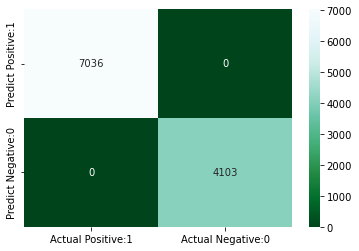

In [88]:
sns.heatmap(cm_t, annot=True, fmt='d', cmap='BuGn_r')

In [80]:
score=[acc,pre,rec,f1,auc]

In [82]:
pd.DataFrame(score,index=['정확도','정밀도','재현율','F1_score','ROC_auc_score'],columns=['summary'])

,summary
정확도,1.0
정밀도,1.0
재현율,1.0
F1_score,1.0
ROC_auc_score,1.0


# 피처선택 후 모델링

In [12]:
# 기본 모델에서 가장 성능이 좋았던 하이퍼 파라미터
svm=SVC(kernel='rbf',C=1.0,gamma=3)

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

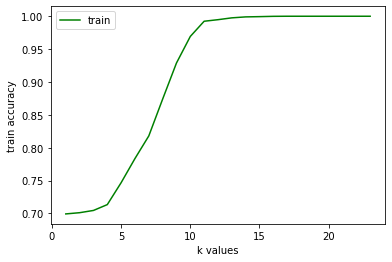

In [176]:
# accuracy_list_train = []
# k=np.arange(1,24,1)
# for each in k:
#     # 1~23개의 피처를 이용해  피처 개수마다 서포트벡터머신 적용
#     x_new = SelectKBest(f_classif, k=each).fit_transform(x_train_s, y_train_s)
#     svm.fit(x_new,y_train_s)
#     # 1~23개 이용할 때 마다 계산된 정확도를 저장
#     accuracy_list_train.append(svm.score(x_new,y_train_s))   

## 피처데이터 개수에 따른 정확도

In [180]:
#select=pd.DataFrame({'features':k,'train accuracy':accuracy_list_train})

In [181]:
#select.to_csv('./select.csv')

In [14]:
select_f=pd.read_csv('./select.csv',index_col=0)

### train data에서 feature 9개만으로 정확도가 90%를 넘고, 17개에서 100%

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
select_f

,features,train accuracy
0,1,0.699212
1,2,0.701075
2,3,0.704487
3,4,0.713375
4,5,0.746729
5,6,0.783494
6,7,0.817902
7,8,0.873881
8,9,0.928826
9,10,0.969273


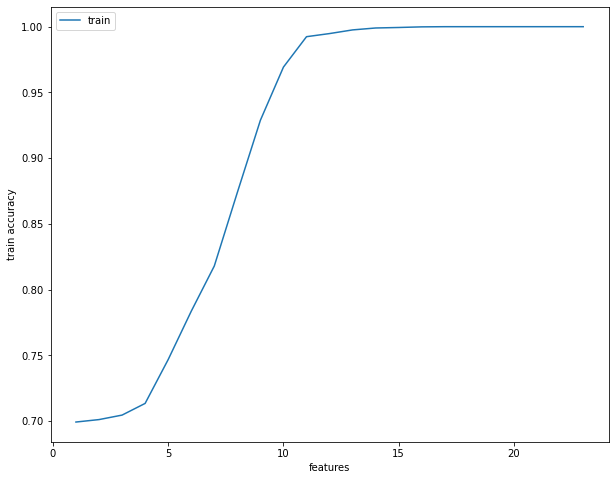

In [17]:
# 베스트 피처개수에 따른 정확도 그래프
plt.figure(figsize=(10,8))
plt.plot(select_f['features'],select_f['train accuracy'])
plt.xlabel("features")
plt.ylabel("train accuracy")
plt.legend(['train'])
plt.show()

## 변수선택 함수

In [31]:
def sel_f(x_train,y_train,k=None):
    sel = SelectKBest(f_classif, k = k )
    x_new = sel.fit_transform(x_train, y_train)
    #x_new_t=sel.fit_transform(x_test_s,y_test_s)
    feat_tr = x_train.columns.values[sel.get_support()]
    #feat_te = x_test_s.columns.values[sel.get_support()]
    #print("x train features:",feat_tr)
    #print("x test features:",feat_te)
    return feat_tr


In [42]:
f9=sel_f(x_train_s,y_train_s,k=9)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 모델링 및 정확도 계산 함수

In [57]:
def modeling(x_tr,y_tr,x_te,y_te,C=None,gamma=None):
    start=time.time()
    model=SVC(kernel='rbf',C=C,gamma=gamma).fit(x_tr,y_tr)
    print(''time.time()-start)
    start2=time.time()
    score_tr=model.score(x_tr, y_tr)
    score_te=model.score(x_te, y_te)
    print('train accuracy : {: .3f}'.format(score_tr))
    print('test accuracy : {: .3f}'.format(score_te))
    print(time.time()-start2)
    return model,score_tr,score_te

## 정확도 계산 예시

### k=16

In [66]:
f16=sel_f(x_train_s,y_train_s,k=16)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [67]:
f16

array(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'systolic',
       'relaxation', 'fasting blood sugar', 'triglyceride', 'HDL',
       'hemoglobin', 'serum creatinine', 'ALT', 'Gtp', 'gender', 'tartar',
       'dental caries'], dtype=object)

In [68]:
sel_x_tr=x_train_s[f16]
sel_x_te=x_test_s[f16]

In [69]:
sel_x_tr.head()

,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,gender,tartar,dental caries
0,-0.348302,-1.049853,-0.458800,-0.083771,-0.550024,-0.313914,-0.255217,-0.624508,1.061947,-1.100546,-0.823115,-0.254602,-0.257586,0,1,0.0
1,-0.348302,-0.506284,-0.458800,-0.116105,-0.184756,-0.623346,1.471806,-0.163686,-1.033346,-1.228353,-1.265418,-0.254602,-0.435020,0,1,0.0
2,0.892501,0.580854,-0.458800,-0.223885,1.203261,1.026958,-0.495081,0.771922,-0.154675,0.752662,0.503794,-0.349076,-0.356161,1,0,0.0
3,-0.348302,0.037285,0.321016,0.638353,-1.572773,-1.654787,-0.159271,1.777351,-0.830575,0.049721,0.503794,-0.034160,-0.435020,1,1,0.0
4,-0.348302,-1.049853,-0.458800,0.422793,-0.111703,-0.210770,-0.926837,-0.736223,0.318456,-1.356160,-1.265418,-0.412060,-0.356161,0,0,0.0


In [70]:
sel_x_te.head()

,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,gender,tartar,dental caries
0,2.960507,-0.506284,-0.068892,0.961692,-0.111703,0.408094,0.608295,-0.833973,0.250866,-0.078086,0.503794,-0.254602,-0.021007,1,0,0.0
1,-1.175504,0.037285,1.880649,1.716150,1.057153,0.717526,-0.159271,-0.373151,0.048096,0.624854,0.061491,0.312248,-0.119581,1,0,0.0
2,-0.348302,0.580854,0.710924,-0.116105,1.203261,1.026958,-0.351163,1.232744,-1.371296,1.136084,-0.823115,0.154790,0.649301,1,0,0.0
3,-0.761903,1.124422,0.321016,-0.223885,2.810438,2.470975,0.032620,0.674172,-0.289855,0.433143,-0.823115,0.879098,0.195858,1,0,0.0
4,-0.761903,-0.506284,0.710924,1.177251,0.253565,0.408094,0.848159,-0.191615,0.048096,0.049721,0.946097,0.973573,0.314147,1,0,0.0


In [75]:
model,score_tr,score_te=modeling(sel_x_tr,y_train_s,sel_x_te,y_test_s,C=1,gamma=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


418.3813736438751
train accuracy :  1.000
test accuracy :  1.000
317.5723805427551


In [76]:
print(model,score_tr,score_te)

SVC(C=1, gamma=3) 0.9998653289340785 0.9997306760032318


In [109]:
print('{:0.3f}'.format(score_tr))

1.000


In [110]:
print('{}'.format(score_tr))

0.9998653289340785


## 평가지표

In [77]:
start = time.time()

pred_t=model.predict(sel_x_te)
confusion_m=confusion_matrix(y_test_s, pred_t)

print("time :", time.time() - start)

time : 64.0483500957489


In [78]:
import seaborn as sns

In [79]:
cm_t = pd.DataFrame(data=confusion_m, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
cm_t

,Actual Positive:1,Actual Negative:0
Predict Positive:1,7036,0
Predict Negative:0,3,4100


<AxesSubplot:>

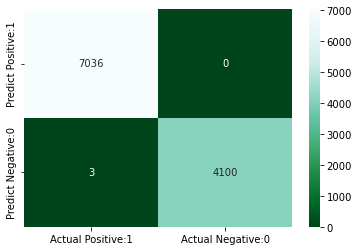

In [80]:
sns.heatmap(cm_t, annot=True, fmt='d', cmap='BuGn_r')

### 정밀도 재현율 f1score

In [81]:
acc=accuracy_score(y_test_s,pred_t)
pre=precision_score(y_test_s , pred_t)
rec=recall_score(y_test_s , pred_t)
f1=f1_score(y_test_s,pred_t)
auc=roc_auc_score(y_test_s, pred_t)

In [84]:
print('정확도 : {:.4f}'.format(acc))
# 정밀도
print('정밀도 : {:.4f}'.format(pre))
# 재현율
print('재현율 : {:.4f}'.format(rec))
# f1_score
print('F1_score : {:.4f}'.format(f1))
# AUC score 
print('ROC_AUC_score : {:.4f}'.format(auc))

정확도 : 0.9997
정밀도 : 1.0000
재현율 : 0.9993
F1_score : 0.9996
ROC_AUC_score : 0.9996


In [85]:
import joblib

In [86]:
joblib.dump(model, './model_k16.pkl')

['./model_k16.pkl']

In [87]:
dir(model)

['C',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_feature_names',
 '_check_n_features',
 '_check_proba',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_intercept_',
 '_more_tags',
 '_n_support',
 '_pairwise',
 '_probA',
 '_probB',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_sparse',
 '_sparse_decision_function',
 '_sparse_fit',
 '_sparse_kernels',
 '_sparse_predict',
 '_sparse_pr

In [88]:
model.feature_names_in_

array(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'systolic',
       'relaxation', 'fasting blood sugar', 'triglyceride', 'HDL',
       'hemoglobin', 'serum creatinine', 'ALT', 'Gtp', 'gender', 'tartar',
       'dental caries'], dtype=object)

### k=17

In [89]:
f17=sel_f(x_train_s,y_train_s,k=17)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [90]:
f17

array(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'triglyceride',
       'HDL', 'hemoglobin', 'serum creatinine', 'ALT', 'Gtp', 'gender',
       'tartar', 'dental caries'], dtype=object)

In [91]:
sel_x_tr=x_train_s[f17]
sel_x_te=x_test_s[f17]

In [92]:
sel_x_tr.head()

,age,height(cm),weight(kg),waist(cm),eyesight(right),systolic,relaxation,fasting blood sugar,triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,gender,tartar,dental caries
0,-0.348302,-1.049853,-0.458800,-0.083771,-0.016643,-0.550024,-0.313914,-0.255217,-0.624508,1.061947,-1.100546,-0.823115,-0.254602,-0.257586,0,1,0.0
1,-0.348302,-0.506284,-0.458800,-0.116105,-0.835046,-0.184756,-0.623346,1.471806,-0.163686,-1.033346,-1.228353,-1.265418,-0.254602,-0.435020,0,1,0.0
2,0.892501,0.580854,-0.458800,-0.223885,-0.425844,1.203261,1.026958,-0.495081,0.771922,-0.154675,0.752662,0.503794,-0.349076,-0.356161,1,0,0.0
3,-0.348302,0.037285,0.321016,0.638353,1.006362,-1.572773,-1.654787,-0.159271,1.777351,-0.830575,0.049721,0.503794,-0.034160,-0.435020,1,1,0.0
4,-0.348302,-1.049853,-0.458800,0.422793,-0.016643,-0.111703,-0.210770,-0.926837,-0.736223,0.318456,-1.356160,-1.265418,-0.412060,-0.356161,0,0,0.0


In [93]:
sel_x_tr.shape

(44553, 17)

In [70]:
sel_x_te.head()

,age,height(cm),weight(kg),waist(cm),systolic,relaxation,fasting blood sugar,triglyceride,HDL,hemoglobin,serum creatinine,ALT,Gtp,gender,tartar,dental caries
0,2.960507,-0.506284,-0.068892,0.961692,-0.111703,0.408094,0.608295,-0.833973,0.250866,-0.078086,0.503794,-0.254602,-0.021007,1,0,0.0
1,-1.175504,0.037285,1.880649,1.716150,1.057153,0.717526,-0.159271,-0.373151,0.048096,0.624854,0.061491,0.312248,-0.119581,1,0,0.0
2,-0.348302,0.580854,0.710924,-0.116105,1.203261,1.026958,-0.351163,1.232744,-1.371296,1.136084,-0.823115,0.154790,0.649301,1,0,0.0
3,-0.761903,1.124422,0.321016,-0.223885,2.810438,2.470975,0.032620,0.674172,-0.289855,0.433143,-0.823115,0.879098,0.195858,1,0,0.0
4,-0.761903,-0.506284,0.710924,1.177251,0.253565,0.408094,0.848159,-0.191615,0.048096,0.049721,0.946097,0.973573,0.314147,1,0,0.0


In [94]:
sel_x_te.shape

(11139, 17)

In [95]:
model2,score_tr2,score_te2=modeling(sel_x_tr,y_train_s,sel_x_te,y_test_s,C=1,gamma=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


452.27866220474243
train accuracy :  1.000
test accuracy :  1.000
707.5232677459717


In [96]:
print(model2,score_tr2,score_te2)

SVC(C=1, gamma=3) 1.0 1.0


In [104]:
model2.feature_names_in_

array(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(right)',
       'systolic', 'relaxation', 'fasting blood sugar', 'triglyceride',
       'HDL', 'hemoglobin', 'serum creatinine', 'ALT', 'Gtp', 'gender',
       'tartar', 'dental caries'], dtype=object)

## 평가지표

In [97]:
start = time.time()

pred_t2=model2.predict(sel_x_te)
confusion_m2=confusion_matrix(y_test_s, pred_t2)

print("time :", time.time() - start)

time : 417.96571159362793


In [98]:
import seaborn as sns

In [99]:
cm_t2 = pd.DataFrame(data=confusion_m2, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])
cm_t2

,Actual Positive:1,Actual Negative:0
Predict Positive:1,7036,0
Predict Negative:0,0,4103


<AxesSubplot:>

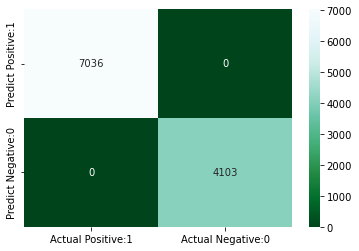

In [100]:
sns.heatmap(cm_t2, annot=True, fmt='d', cmap='BuGn_r')

### 정밀도 재현율 f1score

In [101]:
acc2=accuracy_score(y_test_s,pred_t2)
pre2=precision_score(y_test_s , pred_t2)
rec2=recall_score(y_test_s , pred_t2)
f12=f1_score(y_test_s,pred_t2)
auc2=roc_auc_score(y_test_s, pred_t2)

In [102]:
print('정확도 : {:.4f}'.format(acc2))
# 정밀도
print('정밀도 : {:.4f}'.format(pre2))
# 재현율
print('재현율 : {:.4f}'.format(rec2))
# f1_score
print('F1_score : {:.4f}'.format(f12))
# AUC score 
print('ROC_AUC_score : {:.4f}'.format(auc2))

정확도 : 1.0000
정밀도 : 1.0000
재현율 : 1.0000
F1_score : 1.0000
ROC_AUC_score : 1.0000


In [103]:
joblib.dump(model2, './model_k17.pkl')

['./model_k17.pkl']

### k=9

In [125]:
sel_x_tr=x_train_s[f9]
sel_x_te=x_test_s[f9]


In [126]:
sel_x_tr.head()

,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,Gtp,gender
0,-1.049853,-0.458800,-0.083771,-0.624508,1.061947,-1.100546,-0.823115,-0.257586,0
1,-0.506284,-0.458800,-0.116105,-0.163686,-1.033346,-1.228353,-1.265418,-0.435020,0
2,0.580854,-0.458800,-0.223885,0.771922,-0.154675,0.752662,0.503794,-0.356161,1
3,0.037285,0.321016,0.638353,1.777351,-0.830575,0.049721,0.503794,-0.435020,1
4,-1.049853,-0.458800,0.422793,-0.736223,0.318456,-1.356160,-1.265418,-0.356161,0


In [127]:
sel_x_te.head()

,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,Gtp,gender
0,-0.506284,-0.068892,0.961692,-0.833973,0.250866,-0.078086,0.503794,-0.021007,1
1,0.037285,1.880649,1.716150,-0.373151,0.048096,0.624854,0.061491,-0.119581,1
2,0.580854,0.710924,-0.116105,1.232744,-1.371296,1.136084,-0.823115,0.649301,1
3,1.124422,0.321016,-0.223885,0.674172,-0.289855,0.433143,-0.823115,0.195858,1
4,-0.506284,0.710924,1.177251,-0.191615,0.048096,0.049721,0.946097,0.314147,1


In [65]:
modeling(sel_x_tr,y_train_s,sel_x_te,y_test_s,C=1,gamma=3)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


400.26352524757385
train accuracy :  0.929
test accuracy :  0.928
236.0619125366211


(SVC(C=1, gamma=3), 0.9288263416604943, 0.9277313942005566)

## gender 제거 후 모델링

In [114]:
x_train_g=x_train_s.drop('gender',axis=1)

In [117]:
x_train_g

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,tartar,hearing(right),hearing(left),dental caries
0,-0.348302,-1.049853,-0.458800,-0.083771,0.385691,-0.016643,-0.550024,-0.313914,-0.255217,0.494320,...,-1.100546,-0.214896,-0.823115,-0.430331,-0.254602,-0.257586,1,1.0,1.0,0.0
1,-0.348302,-0.506284,-0.458800,-0.116105,-0.433770,-0.835046,-0.184756,-0.623346,1.471806,-0.137158,...,-1.228353,-0.214896,-1.265418,-0.220763,-0.254602,-0.435020,1,1.0,1.0,0.0
2,0.892501,0.580854,-0.458800,-0.223885,-0.433770,-0.425844,1.203261,1.026958,-0.495081,1.235620,...,0.752662,-0.214896,0.503794,-0.273155,-0.349076,-0.356161,0,1.0,1.0,0.0
3,-0.348302,0.037285,0.321016,0.638353,1.000286,1.006362,-1.572773,-1.654787,-0.159271,3.432064,...,0.049721,-0.214896,0.503794,-0.377939,-0.034160,-0.435020,1,1.0,1.0,0.0
4,-0.348302,-1.049853,-0.458800,0.422793,-0.024040,-0.016643,-0.111703,-0.210770,-0.926837,-0.356803,...,-1.356160,-0.214896,-1.265418,-0.535115,-0.412060,-0.356161,0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44548,0.478900,0.580854,-0.068892,0.638353,0.385691,0.392559,1.933796,1.852111,0.128566,-0.411714,...,0.369240,-0.214896,0.503794,0.984253,0.690148,0.215573,1,1.0,1.0,0.0
44549,-0.761903,1.124422,0.321016,0.207234,-0.843500,-0.630445,-1.207506,-0.210770,-0.543054,-0.274436,...,0.369240,-0.214896,0.061491,-0.325547,-0.412060,-0.474450,1,1.0,1.0,0.0
44550,-0.761903,1.124422,0.321016,-1.204680,1.000286,1.006362,-0.403917,-0.623346,-0.207244,-1.427569,...,-0.781027,-0.214896,0.503794,-0.430331,-0.254602,-0.592740,1,1.0,1.0,0.0
44551,0.478900,0.037285,1.880649,2.664611,-0.433770,-1.039647,0.034404,-0.107626,-0.399135,-0.494080,...,-0.078086,-0.214896,0.061491,0.198373,0.690148,-0.001292,1,1.0,1.0,0.0


In [115]:
x_test_g=x_test_s.drop('gender',axis=1)

In [119]:
x_test_g

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,tartar,hearing(right),hearing(left),dental caries
0,2.960507,-0.506284,-0.068892,0.961692,-0.228905,-0.630445,-0.111703,0.408094,0.608295,-0.768636,...,-0.078086,-0.214896,0.503794,0.145981,-0.254602,-0.021007,0,1.0,1.0,0.0
1,-1.175504,0.037285,1.880649,1.716150,1.000286,1.006362,1.057153,0.717526,-0.159271,1.263075,...,0.624854,-0.214896,0.061491,-0.325547,0.312248,-0.119581,0,1.0,1.0,0.0
2,-0.348302,0.580854,0.710924,-0.116105,1.000286,1.006362,1.203261,1.026958,-0.351163,-0.933369,...,1.136084,-0.214896,-0.823115,-0.063587,0.154790,0.649301,0,1.0,1.0,0.0
3,-0.761903,1.124422,0.321016,-0.223885,-0.024040,-0.016643,2.810438,2.470975,0.032620,1.400353,...,0.433143,-0.214896,-0.823115,0.198373,0.879098,0.195858,0,1.0,1.0,0.0
4,-0.761903,-0.506284,0.710924,1.177251,-0.024040,0.392559,0.253565,0.408094,0.848159,0.439408,...,0.049721,-0.214896,0.946097,0.460333,0.973573,0.314147,0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11134,-0.348302,0.580854,-0.068892,-0.762784,-0.228905,-0.221243,-0.842238,-0.829634,-0.495081,0.439408,...,-1.483968,-0.214896,-1.265418,-0.639899,-0.632501,-0.592740,1,1.0,1.0,1.0
11135,0.065299,-0.506284,-1.238617,-1.301682,0.385691,0.392559,-1.499720,-1.448499,-0.495081,-0.851003,...,-0.397605,-0.214896,0.061491,-0.325547,-0.475043,-0.513880,1,1.0,1.0,0.0
11136,0.892501,-0.506284,-1.238617,-1.463352,-0.024040,0.392559,-0.330863,-0.417058,-0.543054,-1.070647,...,-1.420064,-0.214896,-1.707721,-0.482723,-0.506535,-0.553310,0,1.0,1.0,0.0
11137,1.306103,0.037285,-0.458800,-0.439445,-0.433770,-0.016643,0.837993,-0.004482,0.368431,0.357042,...,-0.141990,-0.214896,-0.823115,-0.325547,-0.254602,-0.435020,0,1.0,1.0,0.0


In [120]:
model_ex=SVC(kernel='rbf',C=1,gamma=3).fit(x_train_g,y_train_s)
score_tr_g=model_ex.score (x_train_g, y_train_s)
score_te_g=model_ex.score (x_test_g, y_test_s)
print('model 훈련 점수 : {: .3f}'.format(score_tr_g))
print('model 테스트 점수 : {: .3f}'.format(score_te_g))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model 훈련 점수 :  1.000
model 테스트 점수 :  1.000


In [123]:
model_ex.feature_names_in_

array(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'systolic', 'relaxation', 'fasting blood sugar',
       'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin',
       'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'tartar',
       'hearing(right)', 'hearing(left)', 'dental caries'], dtype=object)

In [121]:
score_tr_g

1.0

In [122]:
score_te_g

1.0

## 선택된 9개 변수에서 gender 제거, 8개 변수로 모델링

In [133]:
tr=sel_x_tr.drop('gender',axis=1)

In [131]:
te=sel_x_te.drop('gender',axis=1)

In [134]:
tr.head()

,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,Gtp
0,-1.049853,-0.458800,-0.083771,-0.624508,1.061947,-1.100546,-0.823115,-0.257586
1,-0.506284,-0.458800,-0.116105,-0.163686,-1.033346,-1.228353,-1.265418,-0.435020
2,0.580854,-0.458800,-0.223885,0.771922,-0.154675,0.752662,0.503794,-0.356161
3,0.037285,0.321016,0.638353,1.777351,-0.830575,0.049721,0.503794,-0.435020
4,-1.049853,-0.458800,0.422793,-0.736223,0.318456,-1.356160,-1.265418,-0.356161


In [136]:
tr.shape

(44553, 8)

In [135]:
te.head()

,height(cm),weight(kg),waist(cm),triglyceride,HDL,hemoglobin,serum creatinine,Gtp
0,-0.506284,-0.068892,0.961692,-0.833973,0.250866,-0.078086,0.503794,-0.021007
1,0.037285,1.880649,1.716150,-0.373151,0.048096,0.624854,0.061491,-0.119581
2,0.580854,0.710924,-0.116105,1.232744,-1.371296,1.136084,-0.823115,0.649301
3,1.124422,0.321016,-0.223885,0.674172,-0.289855,0.433143,-0.823115,0.195858
4,-0.506284,0.710924,1.177251,-0.191615,0.048096,0.049721,0.946097,0.314147


In [137]:
te.shape

(11139, 8)

In [ ]:
model_8=SVC(kernel='rbf',C=1,gamma=3).fit(tr,y_train_s)
score8=model_8.score (tr, y_train_s)
score8_t=model_8.score (te, y_test_s)
print('model 훈련 점수 : {: .3f}'.format(score8))
print('model 테스트 점수 : {: .3f}'.format(score8_t))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
